# 3D reconstruction and pose estimation

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
plt.rcParams["figure.facecolor"]=(1,1,1,1)

## Camera self-calibration

Camera calibration is needed for accurate 3D reconstruction. It is often performed using a known target object such as a checker board pattern. A tutorial on camera calibration is available [here](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html). For simplicity, we do not perform full calibration in this notebook. Instead, we use a method presented in this [paper](https://pdfs.semanticscholar.org/9145/a453190b87e6530bdf6deb029bec2dc1bb83.pdf) to extract the focal length from the fundamental matrix. Focal length is the most important internal parameter of the camera. We assume that the principal point is located in the center of the image frame and the image does not contain distortion.

This method does not require a known calibration pattern, and it can be applied directly to a stereo pair. Hence, it is called *self-calibration* or *auto-calibration*.

We use the same stereo pair and matches as in the previous example.

In [3]:
img1=cv2.cvtColor(cv2.imread('images/rdimage.001.jpg'),cv2.COLOR_RGB2GRAY)
img2=cv2.cvtColor(cv2.imread('images/rdimage.002.jpg'),cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(img1,None)
kp2, desc2 = sift.detectAndCompute(img2,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(desc1,desc2, k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append([m])
pts1 = np.zeros((len(good), 2))
pts2 = np.zeros((len(good), 2))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    pts1[i,:] = kp1[i1].pt
    pts2[i,:] = kp2[i2].pt

Before computing the fundamental matrix, we normalize the image coordinates by shifting the origin to the principal point.

In [4]:
ppt = np.array(img1.shape[::-1])/2

In [5]:
npt1=pts1-ppt
npt2=pts2-ppt

In [6]:
F, mask = cv2.findFundamentalMat(npt1,npt2,cv2.FM_RANSAC)

Next, we use the singular value decomposition (SVD) to estimate the locations of the epipoles.

In [7]:
U, S, V = np.linalg.svd(F)

In [8]:
ep1=V[2,0:2]/V[2,2]
ep2=U[0:2,2]/U[2,2]

The method works only if the epipoles are on the x axis. Hence, we need to rotate the image coordinates accordingly and then calculate a new fundamental matrix.

In [9]:
th1=-np.arctan2(ep1[1],ep1[0])
th2=np.pi-np.arctan2(ep2[1],ep2[0])

In [10]:
R1=np.array([[np.cos(th1),np.sin(th1),0],[-np.sin(th1),np.cos(th1),0],[0,0,1]])
R2=np.array([[np.cos(th2),np.sin(th2),0],[-np.sin(th2),np.cos(th2),0],[0,0,1]])

In [11]:
F2=np.matmul(np.matmul(R2.T,F),R1)

The algorithm provides focal lengths for both images.

In [12]:
U2,S2,V2 = np.linalg.svd(F2)
e1=V2[2,:]; e2=U2[:,2]
A=np.linalg.inv(np.diag((U2[2,2],1,-U2[0,2])))
B=np.linalg.inv(np.diag((V2[2,2],1,-V2[2,0])))
R=np.matmul(np.matmul(A,F2),B)
a=R[0,0]; b=R[0,1]; c=R[1,0]; d=R[1,1]
f1=np.sqrt(-a*c*e1[0]**2/(a*c*e1[2]**2+b*d))
f2=np.sqrt(-a*b*e2[0]**2/(a*b*e2[2]**2+c*d))

In [13]:
print((f1,f2))

(496.32617006186973, 500.610014956465)


We assume that both images have been captured with the same camera. Hence, we use the average as an estimate of the focal length.

In [14]:
f = (f1+f2)/2

The calibration matrix is finally created.

In [15]:
K = np.array([[f,0,ppt[0]],[0,f,ppt[1]],[0,0,1]])

In [16]:
print(K)

[[498.46809251   0.         384.        ]
 [  0.         498.46809251 256.        ]
 [  0.           0.           1.        ]]


## Triangulation

The calibration matrix provides the relationship between the normalized image coordinates $\tilde{\mathbf{x}}$ and actual image coordinates $\mathbf{x}$ so that $\mathbf{x}=\mathbf{K}\tilde{\mathbf{x}}$. By substituting this to the fundamental matrix constraint $\mathbf{x'}^T \mathbf{F} \mathbf{x} = 0$ we get $\tilde{\mathbf{x'}}^T \mathbf{K}^T\mathbf{F} \mathbf{K} \tilde{\mathbf{x}}$ = 0 where $\mathbf{E}=\mathbf{K}^T\mathbf{F} \mathbf{K}$ is the essential matrix that we calculate next.

In [17]:
E,_ = cv2.findEssentialMat(pts1,pts2,K)

Essential matrix can be decomposed into a rotation matrix $\mathbf{R}$ and a translation vector $\mathbf{t}$ using the following function:

In [18]:
ret, R, t, inliers = cv2.recoverPose(E,pts1,pts2,K)

We use only the points that fulfil the epipolar constraint.

In [19]:
pt1=pts1[inliers.flatten()>0,:]
pt2=pts2[inliers.flatten()>0,:]

Then we can triangulate the points in the 3D space. For that we need the projection matrices for both cameras. We assume that the first image defines the world coordinate system. The 3D point cloud obtained is visualized below.

In [20]:
T=np.hstack((R,t))
P2=np.matmul(K,T)
P1=np.hstack((K,np.zeros((3,1))))

In [21]:
hpt3d=cv2.triangulatePoints(P1,P2,pt1.T,pt2.T)

In [22]:
pt3d=cv2.convertPointsFromHomogeneous(hpt3d.T)

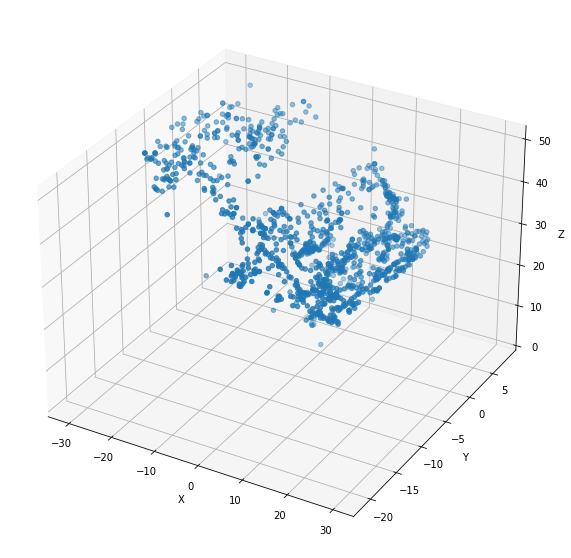

In [23]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pt3d[:,0,0],pt3d[:,0,1],pt3d[:,0,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');

The point cloud can still have outliers that we try to eliminate next by projecting the 3D points back to the image coordinates. We need to convert the rotation matrix to axis-angle representation using the [Rodrigues' formula](https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula). Projected points are shown below with blue dots while original points are represented with red crosses.

In [24]:
rvec,_=cv2.Rodrigues(R)

In [25]:
p1,_=cv2.projectPoints(pt3d, np.zeros((3,1)), np.zeros((3,1)), K, None)
p2,_=cv2.projectPoints(pt3d, rvec, t, K, None)
p1=p1.reshape((len(p1),2))
p2=p2.reshape((len(p2),2))

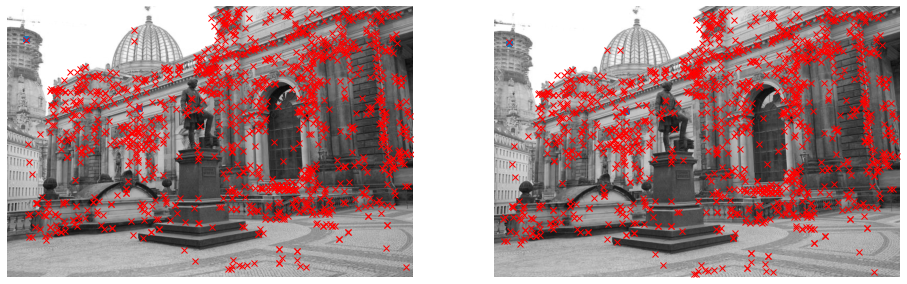

In [26]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.imshow(img1,cmap='gray')
plt.plot(p1[inliers,0],p1[inliers,1],'o')
plt.plot(pt1[:,0],pt1[:,1],'rx')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(img2,cmap='gray')
plt.plot(p2[inliers,0],p2[inliers,1],'o')
plt.plot(pt2[:,0],pt2[:,1],'rx')
plt.axis('off');

We can see that some points do not match which means that they are outliers. We pick those out by thresholding the reprojection error shown below.

In [27]:
er1=abs(pt1-p1).sum(axis=1)
er2=abs(pt2-p2).sum(axis=1)

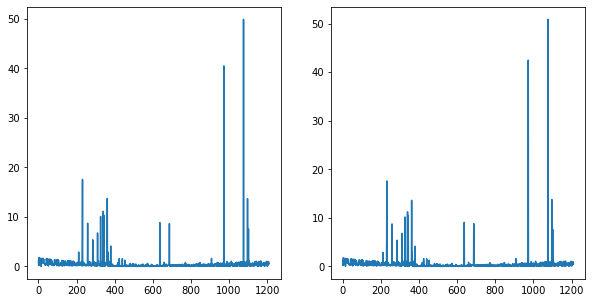

In [28]:
fig = plt.figure(figsize=(10,5))
fig.add_subplot(121)
plt.plot(er1)
fig.add_subplot(122)
plt.plot(er2);

In [29]:
inliers=np.bitwise_and(abs(er1)<5,abs(er2)<5)

In [30]:
p3d=pt3d[inliers]

Finally, we visualize the remaining 3D points from two viewpoints.

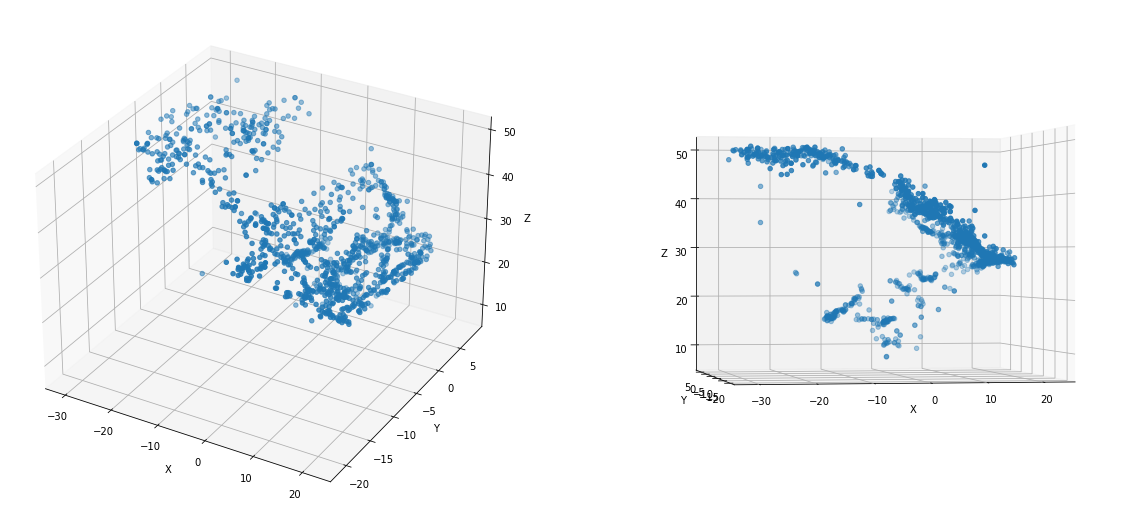

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(p3d[:,0,0],p3d[:,0,1],p3d[:,0,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z');
ax = fig.add_subplot(122, projection='3d')
ax.scatter(p3d[:,0,0],p3d[:,0,1],p3d[:,0,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(0, 260);

## Dense depth estimation

Once we know the camera matrix and the relative pose between the cameras we can also perform stereo matching and produce a dense depth map.

First, we need to rectify the images. In this case, we use functions available for calibrated cameras.

In [32]:
R1,R2,P1,P2,Q,vp1,vp2 = cv2.stereoRectify(K,np.zeros((1,4)),K,np.zeros((1,4)),img1.shape[::-1],R,t)

In [33]:
map1,map2 = cv2.initUndistortRectifyMap(K,np.zeros((1,4)),R1,K,img1.shape[::-1],cv2.CV_16SC2)

In [34]:
rimg1=cv2.remap(img1,map1,map2,cv2.INTER_LINEAR)

In [35]:
map1,map2 = cv2.initUndistortRectifyMap(K,np.zeros((1,4)),R2,K,img2.shape[::-1],cv2.CV_16SC2)

In [36]:
rimg2=cv2.remap(img2,map1,map2,cv2.INTER_LINEAR)

Here are the rectified images:

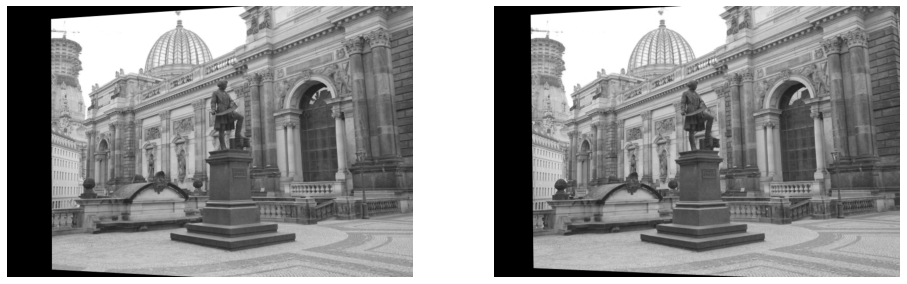

In [37]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(121)
plt.imshow(rimg1,cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(rimg2,cmap='gray')
plt.axis('off');

Then we perform stereo matching to get the disparity map.

In [38]:
stereoM = cv2.StereoSGBM_create(-16,64,7)

In [39]:
disp = stereoM.compute(rimg1, rimg2)

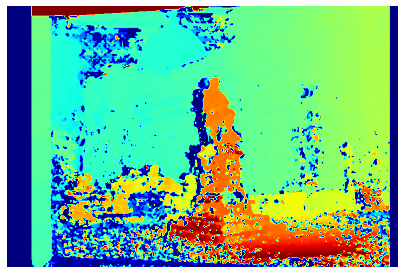

In [40]:
fig = plt.figure(figsize=(7,7))
plt.imshow(disp,cmap='jet')
plt.axis('off');

The disparity map is finally converted to a depth map. Notice that because we only can get the translation between the cameras up to a scale, the depth values obtained also have an arbitrary scale. The resulting depth map is visualized below.

In [41]:
i3d=cv2.reprojectImageTo3D(disp,Q)

In [42]:
# We mask out negative and large depth values
mask=np.bitwise_or(i3d[:,:,2]>5,i3d[:,:,2]<0)
i3d[mask]=np.array((0,0,0))

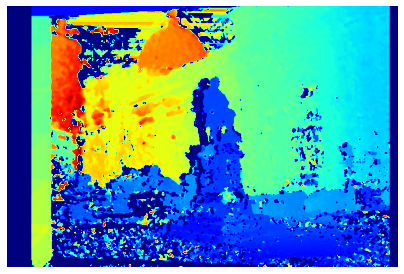

In [43]:
fig = plt.figure(figsize=(7,7))
plt.imshow(i3d[:,:,2],cmap='jet')
plt.axis('off');

## Pose estimation and augmented reality

In this section, we demonstrate how to use camera pose estimation for implementing simple marker-based augmented reality.

First, we read two images, a marker and a test image, that are shown below.

In [44]:
imgc = cv2.imread('images/AR_image2.png')
imgc = cv2.cvtColor(imgc,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(imgc,cv2.COLOR_RGB2GRAY)
marker = cv2.imread('images/AR_marker.png')
marker = cv2.cvtColor(marker,cv2.COLOR_BGR2GRAY)

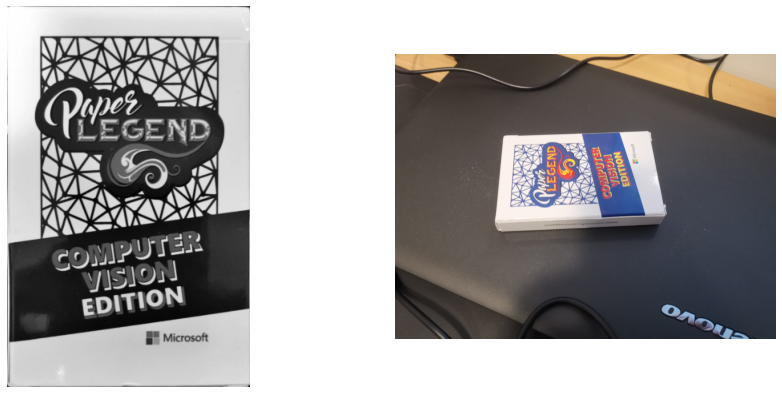

In [45]:
fig = plt.figure(figsize=(15,7))
fig.add_subplot(121)
plt.imshow(marker,cmap='gray')
plt.axis('off')
fig.add_subplot(122)
plt.imshow(imgc)
plt.axis('off');

The aim is to detect the marker from the test image and estimate its 3D pose (position and orientation). We use SIFT features to determine corresponding key points. The matches are shown below.

In [46]:
kpm, descm = sift.detectAndCompute(marker,None)
kpi, desci = sift.detectAndCompute(img,None)

In [47]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descm,desci, k=2)
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

In [48]:
out = cv2.drawMatchesKnn(marker,kpm,img,kpi,good,None,flags=2)

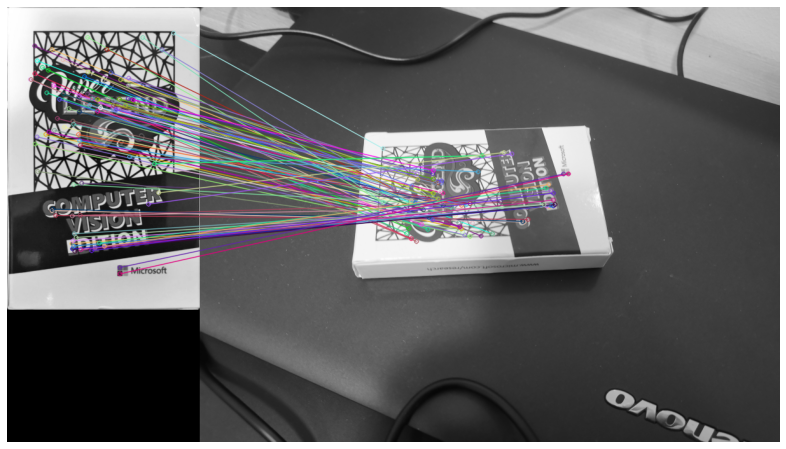

In [49]:
plt.figure(figsize=(15,8))
plt.imshow(out)
plt.axis('off');

We need to represent the matches as 3D to 2D correspondences. The 3D space is defined by the marker image. The origin is in the upper left corner and the x-axis is directed towards the right. To make the coordinate system right-handed with z-axis pointing upwards, we need to invert the y-axis.

In [50]:
pi = np.zeros((len(good), 2))
pm = np.zeros((len(good), 3))
for i in range(len(good)):
    i1 = good[i][0].queryIdx
    i2 = good[i][0].trainIdx
    pi[i,:] = kpi[i2].pt
    pm[i,0:2] = kpm[i1].pt

In [51]:
pm[:,1] = -pm[:,1]

We assume that the image does not contain any lens distortion, the pricipal point is in the center of the image, and the focal length is approximately known. This gives us the following camera matrix:

In [52]:
f=900.0
K=np.array([
    [f,0,456],
    [0,f,342],
    [0,0,1]])

We use the PnP method to get the camera pose.

In [53]:
ret,rvec,tvec,inliers = cv2.solvePnPRansac(pm,pi,K,np.zeros((4,1)))

The rotation vector is in axis-angle representation that we convert to a matrix.

In [54]:
R,_=cv2.Rodrigues(rvec)

We project the 3D points to image coordinates using the estimated pose and the camera matrix.

In [55]:
pc = np.matmul(K,np.matmul(R,pm.T)+tvec)
pt=pc[0:2,:]/pc[2,:]

Then we plot the residual error between the predicted and the actual image points. We use only the inliers provided by the PnP method.

In [56]:
i=inliers.flatten()

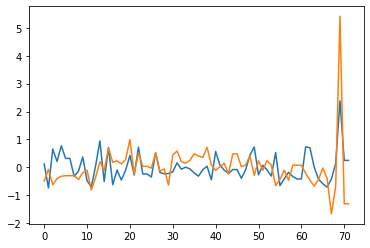

In [57]:
plt.plot(pt[:,i].T-pi[i,:]);

From this plot we can see that the error is relatively small, which indicates that the pose estimate is good enough.

Next, we use [Pyrender](https://pyrender.readthedocs.io/en/latest/) package to render a 3D model on the marker. In order to use the package you need to install it with ``pip install pyrender==0.1.39`` on a GPU-enabled computer.

In [58]:
import trimesh
import pyrender
import os

In [59]:
#Uncomment the following for a GPU-accelerated server without a display manager.
#os.environ['PYOPENGL_PLATFORM'] = 'egl'

First, we create our scene and load the 3D model.

In [60]:
scene = pyrender.Scene(ambient_light=[1.0, 1.0, 1.0],
...                        bg_color=[0.0, 0.0, 0.0])

In [61]:
obj_trimesh = trimesh.load('3Dmodels/Dino.obj')
mesh = pyrender.Mesh.from_trimesh(obj_trimesh)

In [62]:
mesh.bounds.astype(np.int)

array([[-251352, -256038,       0],
       [ 251352,  256038,  605529]])

The model is added to the scene. It is also rescaled and translated to the center of the marker.

In [63]:
me=scene.add(mesh)
me.scale=np.array([1.,1,1])/1500
cx = marker.shape[1]/2
cy = marker.shape[0]/2
me.translation=np.array([cx,-cy,0])

The field of view of the virtual camera is determined by the focal length and the vertical image resolution of the actual camera.

In [64]:
yr=img.shape[0]/2
yfov=np.arctan(yr/f)*2
camera = pyrender.PerspectiveCamera(yfov=yfov, aspectRatio=1.0)

We need to express the camera pose as a 4 $\times$ 4 transformation matrix from camera coordinates to scene coordinates. Moreover, the virtual camera assumes that the z-axis points backwards along the optical axis and the y-axis is directed upwards. That is why we need an additional transformation to perform 180$^{\circ}$ rotation around the x-axis.

In [65]:
T=np.hstack((R,tvec))
T=np.vstack((T,np.array([0,0,0,1])))

In [66]:
Rx=np.array([
    [1.0,0,0,0],
    [0,-1.0,0,0],
    [0,0,-1.0,0],
    [0,0,0,1.0]])

In [67]:
pose=np.matmul(np.linalg.inv(T),Rx)

The camera and a spot light source are added to the scene, and an image of the 3D model is rendered.

In [68]:
cam=scene.add(camera, pose=pose)

In [69]:
light = pyrender.SpotLight(color=np.ones(3), intensity=10000.0,
...                            innerConeAngle=np.pi/12.0,
...                            outerConeAngle=np.pi/3.3)

In [70]:
spot=scene.add(light, pose=pose)

In [71]:
r = pyrender.OffscreenRenderer(img.shape[1], img.shape[0])

In [72]:
color, depth = r.render(scene)

Finally, the virtual object is overlaid to the image. The result is shown below.

In [73]:
mask=(depth==0).astype(np.uint8)*255
result = cv2.bitwise_and(imgc,imgc,mask=mask)
result = result + color

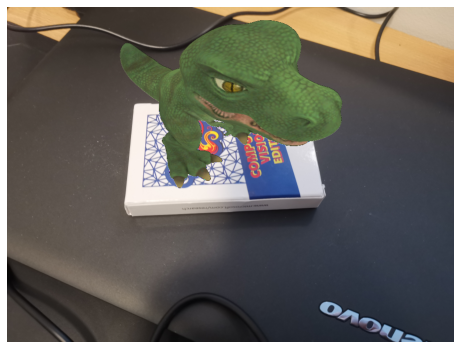

In [74]:
plt.figure(figsize=(8,8))
plt.imshow(result);
plt.axis('off');